In [1]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,sz_o,opts = args['h0'],args['h'],args['times'], args['sz_o'], args['opts']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_o],args = params)
    return out.expect, beta, Jvalue

print("Function definition complete!!")

Function definition complete!!


## $\langle \psi(t) \vert \hat{\sigma}^z_0 \hat{\sigma}^z_7 \vert \psi(t)\rangle$

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


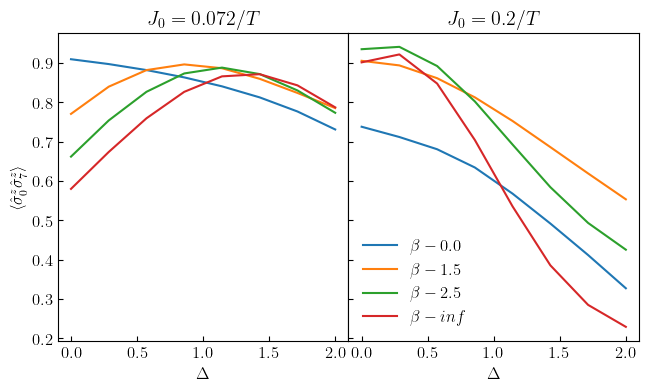

CPU times: user 356 ms, sys: 132 ms, total: 488 ms
Wall time: 2min 3s


In [57]:
%%time
from qutip import sigmax, sigmay, sigmaz
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})

freezing_pts = jn_zeros(0, 5)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
sample_rate = 10
time_periods = 100
times = np.linspace(0,T * time_periods, sample_rate * time_periods)

ea, eb = 0.03, 0.9
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]     

hpt = jn_zeros(0,3)[0]
lamb = 0.0
lambd_x = lamb
lambd_y = lamb

sx,sy,sz = sigmax(), sigmay(), sigmaz()   
h = hpt * w/4
datap = np.zeros((N, len(times)))
            
# Define the hamiltonian at the position i,j = 0, 7
pos1, pos2 = 0, 7
i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor_0_7 = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

# Define a single spin Hamiltonian
pos_0 = 0
id = qeye(2**pos_0)
dim12 = N-1-pos_0
id1 = qeye(2**dim12)
sz_0 = Qobj(tensor(id,tensor(sz,id1)).full())


pos_0 = 7
id = qeye(2**pos_0)
dim12 = N-1-pos_0
id1 = qeye(2**dim12)
sz_7 = Qobj(tensor(id,tensor(sz,id1)).full())

nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4)

deltas = np.linspace(0,2,8)
betas = [0.0, 1.5, 2.5, float('inf')]

twoTtimes = np.linspace(0, T * time_periods, int(time_periods/2)+1)
idx = np.searchsorted(times, twoTtimes)

for beta in betas: 
    params1 = [{'h0':0, 'h':h+delt, 'omega':omega, 'N':N,'N1':N1,\
                'opts':opts,'sz_o':sz_cor_0_7, 'lambd_x':lambd_x,\
                'lambd_y':lambd_y, 'Jvalue':Jvalues[0],'beta':beta,\
                'g':g,'ea':ea,'eb':eb, 'times':times} for delt in deltas]
    
    params2 = [{'h0':0, 'h':h+delt, 'omega':omega, 'N':N,'N1':N1,\
                'opts':opts,'sz_o':sz_cor_0_7, 'lambd_x':lambd_x,\
                'lambd_y':lambd_y, 'Jvalue':Jvalues[1],'beta':beta,\
                'g':g,'ea':ea,'eb':eb, 'times':times} for delt in deltas]

    params = params1 + params2
    data = p.map(run_dynm,tqdm(params))
    
    sz_tau = np.array([np.average(data[i][0][0][idx]) for i in range(2*len(deltas))])
    sz_t = sz_tau.reshape((2, len(deltas)))
    
    axs[0].plot(deltas, sz_t[0], label = fr"$\beta-{beta}$")
    axs[1].plot(deltas, sz_t[1], label = fr"$\beta-{beta}$")
    axs[0].set_xlabel(r'$\Delta$')
    axs[1].set_xlabel(r'$\Delta$')
    axs[0].set_ylabel(r'$\langle\hat{\sigma}^z_0 \hat{\sigma}^z_7\rangle$')
    axs[0].tick_params(which='both', axis="both", direction="in")
    axs[1].tick_params(which='both', axis="both", direction="in")
    axs[0].set_title(r"$J_0 = 0.072/T$")
    axs[1].set_title(r"$J_0 = 0.2/T$")
    
plt.legend(frameon = False)
plt.show()

# Autocorrelation 


In [1]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm_corr(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,sz_o,opts = args['h0'],args['h'],args['times'], args['sz_o'], args['opts']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    corr_vec = correlation_2op_1t(H, grket, times, [], sz_o, sz_o, args = params)
    return corr_vec

print("Function definition complete!!")

Function definition complete!!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:25<00:00,  5.36s/it]


CPU times: user 166 ms, sys: 92.1 ms, total: 258 ms
Wall time: 4min 17s


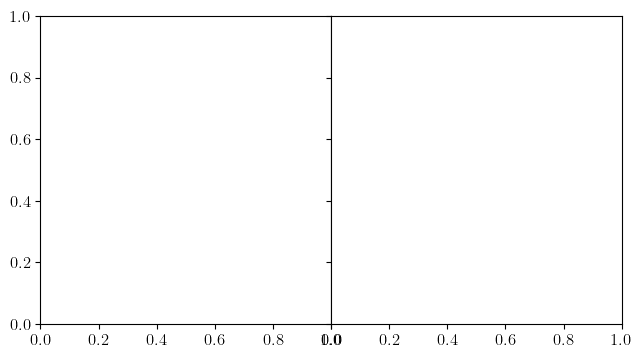

In [8]:
%%time
from qutip import sigmax, sigmay, sigmaz
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})

freezing_pts = jn_zeros(0, 5)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
sample_rate = 10
time_periods = 2
times = np.linspace(0,T * time_periods, sample_rate * time_periods)

ea, eb = 0.03, 0.9
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]     

hpt = jn_zeros(0,3)[0]
lamb = 0.0
lambd_x = lamb
lambd_y = lamb

sx,sy,sz = sigmax(), sigmay(), sigmaz()   
h = hpt * w/4
datap = np.zeros((N, len(times)))
            
# Define the hamiltonian at the position i,j = 0, 7
pos1, pos2 = 0, 7
i,j = pos1, pos2
id = qeye(2**i)
dim11 = j-i-1
id1 = qeye(2**dim11)
dim12 = N-1-j
id2 = qeye(2**dim12)
sz_cor_0_7 = Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) 

# Define a single spin Hamiltonian
pos_0 = 0
id = qeye(2**pos_0)
dim12 = N-1-pos_0
id1 = qeye(2**dim12)
sz_0 = Qobj(tensor(id,tensor(sz,id1)).full())


pos_0 = 7
id = qeye(2**pos_0)
dim12 = N-1-pos_0
id1 = qeye(2**dim12)
sz_7 = Qobj(tensor(id,tensor(sz,id1)).full())

nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4)

deltas = np.linspace(0,2,8)
betas = [0.0, 1.5, 2.5, float('inf')]

twoTtimes = np.linspace(0, T * time_periods, int(time_periods/2)+1)
idx = np.searchsorted(times, twoTtimes)

for beta in betas: 
    params1 = [{'h0':0, 'h':w/4 * (hpt +delt), 'omega':omega, 'N':N,'N1':N1,\
                'opts':opts,'sz_o':sz_0, 'lambd_x':lambd_x,\
                'lambd_y':lambd_y, 'Jvalue':Jvalues[0],'beta':beta,\
                'g':g,'ea':ea,'eb':eb, 'times':times} for delt in deltas]
    
    params2 = [{'h0':0, 'h':w/4 * (hpt +delt), 'omega':omega, 'N':N,'N1':N1,\
                'opts':opts,'sz_o':sz_0, 'lambd_x':lambd_x,\
                'lambd_y':lambd_y, 'Jvalue':Jvalues[1],'beta':beta,\
                'g':g,'ea':ea,'eb':eb, 'times':times} for delt in deltas]

    params = params1 + params2
    data = p.map(run_dynm_corr,tqdm(params))
    sz_tau = np.array([np.average(data[i][idx]) for i in range(2*len(deltas))])
    sz_t = sz_tau.reshape((2, len(deltas)))
    
    axs[0].plot(deltas, sz_t[0], label = fr"$\beta-{beta}$")
    axs[1].plot(deltas, sz_t[1], label = fr"$\beta-{beta}$")
    axs[0].set_xlabel(r'$\Delta$')
    axs[1].set_xlabel(r'$\Delta$')
    axs[0].set_ylabel(r'$\langle\hat{\sigma}^z_0 \hat{\sigma}^z_7\rangle$')
    axs[0].tick_params(which='both', axis="both", direction="in")
    axs[1].tick_params(which='both', axis="both", direction="in")
    axs[0].set_title(r"$J_0 = 0.072/T$")
    axs[1].set_title(r"$J_0 = 0.2/T$")
    
plt.legend(frameon = False)
plt.show()



In [10]:
data[0]

array([ 1.        +0.j,  0.80117138+0.j,  0.2837511 +0.j, -0.34650486+0.j,
       -0.83897064+0.j, -0.99549878+0.j, -0.99367609+0.j, -0.99008956+0.j,
       -0.98779426+0.j, -0.98588   +0.j, -0.90066651+0.j, -0.47566895+0.j,
        0.13848181+0.j,  0.69756425+0.j,  0.97925517+0.j,  0.99278382+0.j,
        0.99443755+0.j,  0.99215395+0.j,  0.98941435+0.j,  0.98819069+0.j])

/home/mahbub/anaconda3/envs/p3p8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


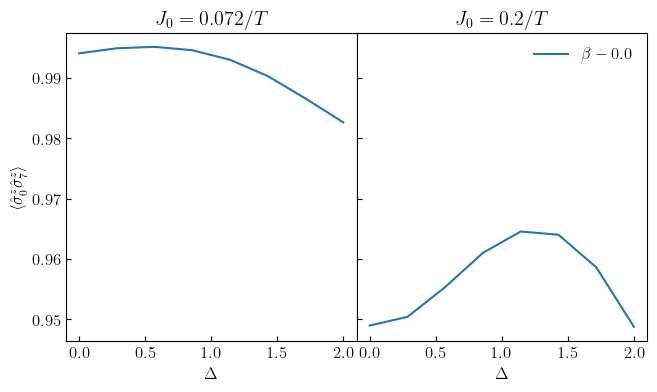

In [11]:
plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})

freezing_pts = jn_zeros(0, 5)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

sz_tau = np.array([np.average(data[i][idx]) for i in range(2*len(deltas))])
sz_t = sz_tau.reshape((2, len(deltas)))

axs[0].plot(deltas, sz_t[0], label = fr"$\beta-{beta}$")
axs[1].plot(deltas, sz_t[1], label = fr"$\beta-{beta}$")
axs[0].set_xlabel(r'$\Delta$')
axs[1].set_xlabel(r'$\Delta$')
axs[0].set_ylabel(r'$\langle\hat{\sigma}^z_0 \hat{\sigma}^z_7\rangle$')
axs[0].tick_params(which='both', axis="both", direction="in")
axs[1].tick_params(which='both', axis="both", direction="in")
axs[0].set_title(r"$J_0 = 0.072/T$")
axs[1].set_title(r"$J_0 = 0.2/T$")
    
plt.legend(frameon = False)
plt.show()

